# Cosmic Star Formation Histories

Plot the main star formation histories over redshift and lookback time.

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from hoki.constants import BPASS_METALLICITIES, BPASS_NUM_METALLICITIES
import matplotlib as mpl
from pylab import cm
from matplotlib.ticker import NullFormatter

In [24]:
import scipy.integrate
from scipy.optimize import fminbound

@np.vectorize
def calc_LB(z, omega0, omega1, hubble):
    '''
    Calculates the lookback time according to Hobbs.

    Parameters:
    z : float
        The redshift at which you want to calculate the lookback
    omega0 : float
        The Matter density parameter (0.3111 Planck 2018)
    omega1 : float
        The dark energy density parameter (0.6889 Planck 2018)
    hubble : float
        The hubble parameters (0.6766 Planck 2018)
    '''
    def func(x):
        E = np.sqrt(omega0*(1+x)**3 + omega1)
        return 1/((1+x)*E)
    # can be simplified by already doing the extra coefficient calculations
    t_hubble = (1/(100*hubble))*3.0856776*10**19
    return t_hubble *scipy.integrate.quad(func, 0, z)[0]/(60*60*24*365.2388526*1e9)


@np.vectorize
def approxZ(LB, omega0, omega1, hubble):
    """Internal function to convert a redshift into a lookback time.

    Parameters:
    LB : float
        lookback time in yrs
    omega0 : float
        the matter density parameter (0.3111 Planck 2018)
    omega1 : float
        The dark energy density parameter (0.6889 Planck 2018)
    hubble : float
        the hubble parameter (0.6766 Planck 2018)
    """
    zmin = 1e-8
    zmax = 1000
    ztol = 1e-8
    maxfun = 5000
    f = lambda z : abs(calc_LB(z, omega0, omega1, hubble) - LB)

    z, _, _, _ = fminbound(f, zmin, zmax, maxfun=maxfun, full_output=1, xtol=ztol)
    return z

In [3]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams.update({'font.size': 22})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [5]:
path = "../data/"

In [7]:
file = h5py.File(f"{path}/data.h5", "r")
SFH = file["SFH"]

In [18]:
h = SFH.attrs['h']
omega_M = SFH.attrs['omega_M']
omega_L = SFH.attrs['omega_L']

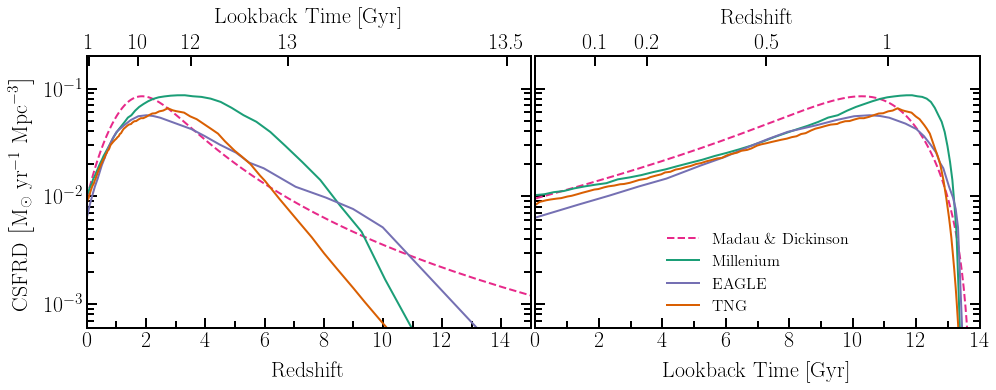

In [22]:
fig, axes = plt.subplots(1,2,figsize=(16,5))
plt.subplots_adjust(wspace=0.01)

ax = axes[0]

# Set the minor and major ticks on both axes
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

# set the location of the ticks
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_yscale('log')
ax.set_xlim(0,15)
ax.set_ylim(6e-4,2e-1)


ax.plot(SFH['empirical'].attrs["redshift"], np.sum(SFH['empirical'], axis=0), "--", label=r"Madau & Dickinson", lw=2,color="#e7298a")
ax.plot(SFH['millimillennium'].attrs['redshift'], np.sum(SFH["millimillennium"], axis=0), label="Millenium", lw=2, color="#1b9e77")
ax.plot(SFH['EAGLE'].attrs['redshift'], np.sum(SFH["EAGLE"], axis=0), label="EAGLE", lw=2, color="#7570b3")
ax.plot(SFH['TNG'].attrs['redshift'], np.sum(SFH["TNG"], axis=0), label="TNG", lw=2, color="#d95f02")


#ax.legend(bbox_to_anchor=(0.98, 0.98), loc=1, frameon=False, fontsize=16)

ax.set_ylabel(r"CSFRD $\left[\textrm{M}_\odot \textrm{ yr}^{-1} \textrm{ Mpc}^{-3} \right]$", labelpad=10)
ax.set_xlabel("Redshift", labelpad=10)


# Create lookback axis on top
# Create new axes object by cloning the y-axis of the first plot
ax2 = ax.twiny()
# Edit the tick parameters of the new x-axis
ax2.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax2.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in')
ax2.set_xlim(0,15)
LB_values = np.array([1, 10, 12, 13, 13.5])
ax2.xaxis.set_major_locator(mpl.ticker.FixedLocator(approxZ(LB_values, omega_M, omega_L, h)))
ax2.set_xticklabels(["1", "10", "12", "13", "13.5"])
ax2.set_xlabel('Lookback Time [Gyr]', labelpad=10)



ax = axes[1]
# Set the minor and major ticks on both axes
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

# set the location of the ticks
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))


ax.set_yscale('log')
ax.set_xlim(0,14)
ax.set_ylim(6e-4,2e-1)

ax.plot(calc_LB(SFH['empirical'].attrs["redshift"], omega_M, omega_L, h),
        np.sum(SFH['empirical'], axis=0),
        "--",
        label=r"Madau \& Dickinson",
        lw=2,
        color="#e7298a")

ax.plot(calc_LB(SFH['millimillennium'].attrs["redshift"], omega_M, omega_L, h),
        np.sum(SFH['millimillennium'], axis=0),
        label="Millenium", 
        lw=2, 
        color="#1b9e77")

ax.plot(calc_LB(SFH['EAGLE'].attrs["redshift"], omega_M, omega_L, h), 
        np.sum(SFH['EAGLE'], axis=0),
        label="EAGLE",
        lw=2,
        color="#7570b3")

ax.plot(calc_LB(SFH['TNG'].attrs["redshift"], omega_M, omega_L, h), 
        np.sum(SFH["TNG"], axis=0),
        label="TNG",
        lw=2,
        color="#d95f02")


ax.legend(loc=8, frameon=False, fontsize=16)

#plt.ylabel("CSFRD [M$_\odot$/yr/Mpc$^3$]", labelpad=10)
ax.set_xlabel("Lookback Time [Gyr]", labelpad=10)

# Create Redshift axis on top
# Create new axes object by cloning the y-axis of the first plot
ax2 = ax.twiny()
# Edit the tick parameters of the new x-axis
ax2.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax2.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in')
ax2.set_xlim(0,10)
z_values = [0.1, 0.2, 0.5, 1, 2, 3, 5, 10]
ax2.xaxis.set_major_locator(mpl.ticker.FixedLocator(calc_LB(z_values, omega_M, omega_L, h)))
ax2.set_xticklabels(z_values)
ax2.set_xlabel('Redshift', labelpad=10)

ax.set_yticklabels([])

plt.savefig("images/png/main_SFH.png", dpi=150, bbox_inches='tight')
plt.savefig("images/pdf/main_SFH.pdf", bbox_inches='tight')
#plt.savefig("SFH_lookbacktime.png", dpi=150)
plt.show()

In [23]:
file.close()